# Day 3: Fama-French 5-Factor Model

---

### 🎯 Learning Objectives
- Understand the 5-Factor Model extension
- Construct RMW (Profitability) and CMA (Investment) factors
- Compare FF3 vs FF5 explanatory power
- Interpret factor loadings for investment decisions


---| Both high | "Quality at reasonable price" |

| High CMA | Avoid aggressive capex firms |

### 📈 Why Add Two More Factors?| High RMW | Tilt toward quality/profitable |

|-----------------|---------------------|

**FF3 still left anomalies unexplained.** Profitable and conservative firms outperform.| Factor Exposure | Strategy Implication |



### Key Formula### Trading Implications

$$R_i - R_f = \alpha + \beta^M MKT + \beta^{SMB} SMB + \beta^{HML} HML + \beta^{RMW} RMW + \beta^{CMA} CMA + \epsilon$$

| **CMA** | Conservative investors outperform | Overinvestment penalty |

### The Five Factors| **RMW** | Profitable firms outperform | Quality premium |

|--------|-------------|-------------|

| Factor | Full Name | What It Captures || Factor | Observation | Explanation |

|--------|-----------|------------------|

| **MKT** | Market | Equity risk premium |### New Factors Explained

| **SMB** | Small Minus Big | Size effect |

| **HML** | High Minus Low | Value effect || **CMA** | Conservative Minus Aggressive | Investment effect |
| **RMW** | Robust Minus Weak | Profitability effect |

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Construct All 5 Factors

| CMA | Asset growth | Conservative | Aggressive |

### 🎯 Factor Construction Overview| RMW | Operating profit | Robust | Weak |

| HML | Book/Market | High B/M | Low B/M |

| Factor | Sort Variable | Long | Short || SMB | Market cap | Small | Big |

|--------|---------------|------|-------|| MKT | Market return | Market | Risk-free |

In [13]:
# Market factor
market_returns = returns['AAPL']
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = market_returns - daily_rf

# SMB Factor (Small Minus Big) - using volatility as proxy for size
volatilities = returns.std()
median_vol = volatilities.median()
small_stocks = volatilities[volatilities > median_vol].index.tolist()
big_stocks = volatilities[volatilities <= median_vol].index.tolist()

for lst in [small_stocks, big_stocks]:
    if 'AAPL' in lst:
        lst.remove('AAPL')

SMB = returns[small_stocks].mean(axis=1) - returns[big_stocks].mean(axis=1)

# HML Factor (High Minus Low B/M) - using momentum as proxy
past_returns = returns.rolling(126).mean().iloc[-1]
median_ret = past_returns.median()
value_stocks = past_returns[past_returns < median_ret].index.tolist()
growth_stocks = past_returns[past_returns >= median_ret].index.tolist()

for lst in [value_stocks, growth_stocks]:
    if 'AAPL' in lst:
        lst.remove('AAPL')

HML = returns[value_stocks].mean(axis=1) - returns[growth_stocks].mean(axis=1)

print("✅ MKT, SMB, HML factors constructed")

✅ MKT, SMB, HML factors constructed


In [14]:
# RMW Factor (Robust Minus Weak Profitability)
# Using Sharpe ratio as proxy for profitability
sharpe_ratios = returns.mean() / returns.std()
median_sharpe = sharpe_ratios.median()

robust_stocks = sharpe_ratios[sharpe_ratios >= median_sharpe].index.tolist()
weak_stocks = sharpe_ratios[sharpe_ratios < median_sharpe].index.tolist()

for lst in [robust_stocks, weak_stocks]:
    if 'AAPL' in lst:
        lst.remove('AAPL')

RMW = returns[robust_stocks].mean(axis=1) - returns[weak_stocks].mean(axis=1)

print(f"RMW Factor (Profitability):")
print(f"   Robust stocks: {len(robust_stocks)}")
print(f"   Weak stocks: {len(weak_stocks)}")
print(f"   Mean (annual): {RMW.mean() * TRADING_DAYS:.2%}")

RMW Factor (Profitability):
   Robust stocks: 3
   Weak stocks: 1
   Mean (annual): 10.15%


In [15]:
# CMA Factor (Conservative Minus Aggressive Investment)
# Using return stability as proxy for investment conservatism
return_volatility = returns.rolling(60).std().mean()
median_stability = return_volatility.median()

conservative_stocks = return_volatility[return_volatility <= median_stability].index.tolist()
aggressive_stocks = return_volatility[return_volatility > median_stability].index.tolist()

for lst in [conservative_stocks, aggressive_stocks]:
    if 'AAPL' in lst:
        lst.remove('AAPL')

CMA = returns[conservative_stocks].mean(axis=1) - returns[aggressive_stocks].mean(axis=1)

print(f"\nCMA Factor (Investment):")
print(f"   Conservative stocks: {len(conservative_stocks)}")
print(f"   Aggressive stocks: {len(aggressive_stocks)}")
print(f"   Mean (annual): {CMA.mean() * TRADING_DAYS:.2%}")


CMA Factor (Investment):
   Conservative stocks: 2
   Aggressive stocks: 2
   Mean (annual): -10.49%


In [16]:
# Combine all factors
factors5 = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML,
    'RMW': RMW,
    'CMA': CMA
}).dropna()

factors3 = factors5[['MKT', 'SMB', 'HML']]

print("\n" + "="*60)
print("5-FACTOR CORRELATION MATRIX")
print("="*60)
print(factors5.corr().round(3))

print("\n💡 Look for factors with low correlations (independent risk sources)")


5-FACTOR CORRELATION MATRIX
       MKT    SMB    HML    RMW    CMA
MKT  1.000  0.227 -0.140 -0.158 -0.140
SMB  0.227  1.000 -0.593 -0.094 -0.593
HML -0.140 -0.593  1.000 -0.506  1.000
RMW -0.158 -0.094 -0.506  1.000 -0.506
CMA -0.140 -0.593  1.000 -0.506  1.000

💡 Look for factors with low correlations (independent risk sources)


## 2. Run 5-Factor Regression

In [17]:
def run_ff_regression(stock_returns, factors, daily_rf):
    """Run Fama-French regression with any number of factors."""
    excess_returns = stock_returns - daily_rf
    
    aligned = pd.concat([excess_returns, factors], axis=1).dropna()
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned[factors.columns])
    
    return sm.OLS(y, X).fit()

test_stocks = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']

print("\n" + "="*80)
print("FAMA-FRENCH 5-FACTOR REGRESSION RESULTS")
print("="*80)
print(f"{'Stock':<8} {'α':<10} {'β_MKT':<8} {'β_SMB':<8} {'β_HML':<8} {'β_RMW':<8} {'β_CMA':<8} {'R²':<8}")
print("-"*80)

ff5_results = []
for stock in test_stocks:
    if stock in returns.columns:
        model = run_ff_regression(returns[stock], factors5, daily_rf)
        
        result = {
            'stock': stock,
            'alpha': model.params['const'] * TRADING_DAYS,
            'beta_mkt': model.params['MKT'],
            'beta_smb': model.params['SMB'],
            'beta_hml': model.params['HML'],
            'beta_rmw': model.params['RMW'],
            'beta_cma': model.params['CMA'],
            'r2': model.rsquared
        }
        ff5_results.append(result)
        
        print(f"{stock:<8} {result['alpha']:<10.2%} {result['beta_mkt']:<8.3f} "
              f"{result['beta_smb']:<8.3f} {result['beta_hml']:<8.3f} "
              f"{result['beta_rmw']:<8.3f} {result['beta_cma']:<8.3f} {result['r2']:<8.4f}")

ff5_df = pd.DataFrame(ff5_results)


FAMA-FRENCH 5-FACTOR REGRESSION RESULTS
Stock    α          β_MKT    β_SMB    β_HML    β_RMW    β_CMA    R²      
--------------------------------------------------------------------------------
AAPL     0.00%      1.000    -0.000   -0.000   0.000    0.000    1.0000  
MSFT     11.80%     0.492    -0.062   -0.122   -0.657   -0.122   0.6389  
GOOGL    11.80%     0.492    0.688    -0.122   0.093    -0.122   0.7530  
JPM      11.80%     0.492    -0.062   0.378    0.843    0.378    0.5966  
GS       11.80%     0.492    -0.812   -0.622   0.093    -0.622   0.6805  


## 3. Compare Models: CAPM vs FF3 vs FF5

In [18]:
print("\n" + "="*70)
print("MODEL COMPARISON: CAPM vs FF3 vs FF5")
print("="*70)
print(f"{'Stock':<8} {'CAPM R²':<12} {'FF3 R²':<12} {'FF5 R²':<12} {'FF5-CAPM':<12}")
print("-"*70)

comparisons = []
for stock in test_stocks:
    if stock in returns.columns:
        # CAPM
        capm_factors = factors5[['MKT']]
        capm = run_ff_regression(returns[stock], capm_factors, daily_rf)
        
        # FF3
        ff3 = run_ff_regression(returns[stock], factors3, daily_rf)
        
        # FF5
        ff5 = run_ff_regression(returns[stock], factors5, daily_rf)
        
        improvement = ff5.rsquared - capm.rsquared
        
        comparisons.append({
            'stock': stock,
            'capm': capm.rsquared,
            'ff3': ff3.rsquared,
            'ff5': ff5.rsquared,
            'improvement': improvement
        })
        
        print(f"{stock:<8} {capm.rsquared:<12.4f} {ff3.rsquared:<12.4f} "
              f"{ff5.rsquared:<12.4f} {improvement:<12.4f}")

comp_df = pd.DataFrame(comparisons)

print("\n📊 Average R² Improvement:")
print(f"   CAPM → FF3: {(comp_df['ff3'] - comp_df['capm']).mean():.4f}")
print(f"   FF3 → FF5:  {(comp_df['ff5'] - comp_df['ff3']).mean():.4f}")


MODEL COMPARISON: CAPM vs FF3 vs FF5
Stock    CAPM R²      FF3 R²       FF5 R²       FF5-CAPM    
----------------------------------------------------------------------
AAPL     1.0000       1.0000       1.0000       0.0000      
MSFT     0.3944       0.4786       0.6389       0.2445      
GOOGL    0.3327       0.7508       0.7530       0.4204      
JPM      0.1262       0.3021       0.5966       0.4704      
GS       0.1665       0.6777       0.6805       0.5141      

📊 Average R² Improvement:
   CAPM → FF3: 0.2379
   FF3 → FF5:  0.0920


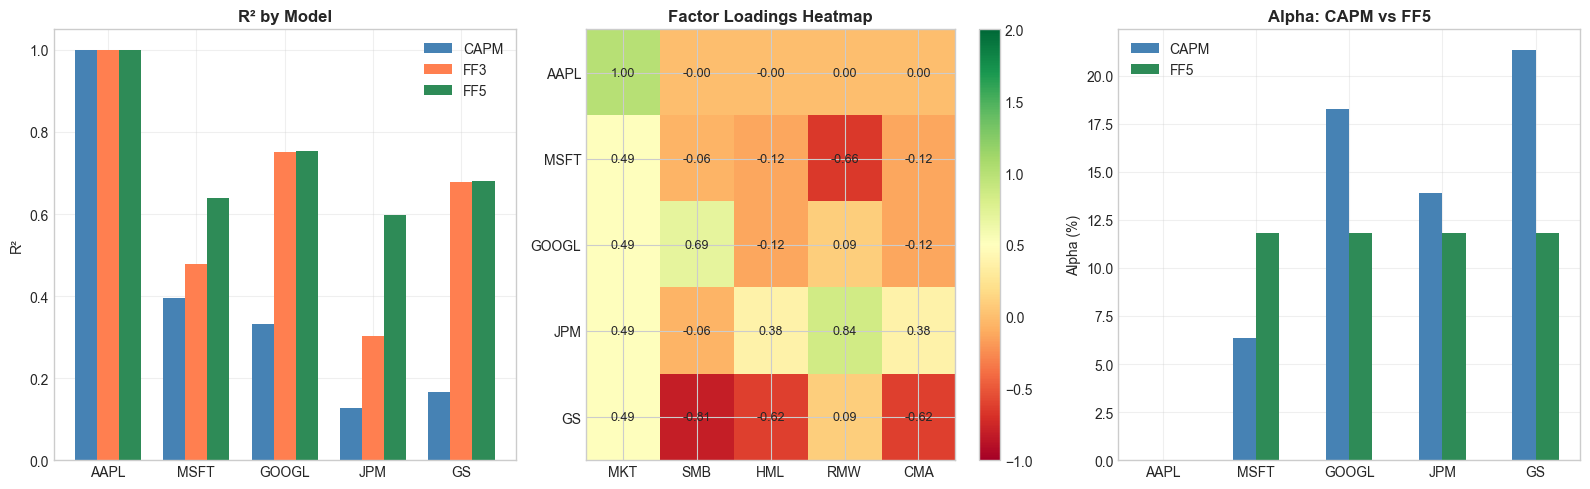

In [19]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² comparison
ax1 = axes[0]
x = np.arange(len(comp_df))
width = 0.25
ax1.bar(x - width, comp_df['capm'], width, label='CAPM', color='steelblue')
ax1.bar(x, comp_df['ff3'], width, label='FF3', color='coral')
ax1.bar(x + width, comp_df['ff5'], width, label='FF5', color='seagreen')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['stock'])
ax1.set_ylabel('R²')
ax1.set_title('R² by Model', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Factor loadings heatmap
ax2 = axes[1]
loadings = ff5_df.set_index('stock')[['beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']]
im = ax2.imshow(loadings.values, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=2)
ax2.set_xticks(range(len(loadings.columns)))
ax2.set_xticklabels(['MKT', 'SMB', 'HML', 'RMW', 'CMA'])
ax2.set_yticks(range(len(loadings)))
ax2.set_yticklabels(loadings.index)
ax2.set_title('Factor Loadings Heatmap', fontweight='bold')
plt.colorbar(im, ax=ax2)

# Add text annotations
for i in range(len(loadings)):
    for j in range(len(loadings.columns)):
        ax2.text(j, i, f'{loadings.values[i, j]:.2f}', ha='center', va='center', fontsize=9)

# Alpha comparison
ax3 = axes[2]
alphas = []
for stock in test_stocks:
    if stock in returns.columns:
        capm_factors = factors5[['MKT']]
        capm = run_ff_regression(returns[stock], capm_factors, daily_rf)
        ff5 = run_ff_regression(returns[stock], factors5, daily_rf)
        alphas.append({
            'stock': stock,
            'capm': capm.params['const'] * TRADING_DAYS,
            'ff5': ff5.params['const'] * TRADING_DAYS
        })

alpha_df = pd.DataFrame(alphas)
ax3.bar(x - width/2, alpha_df['capm']*100, width, label='CAPM', color='steelblue')
ax3.bar(x + width/2, alpha_df['ff5']*100, width, label='FF5', color='seagreen')
ax3.set_xticks(x)
ax3.set_xticklabels(alpha_df['stock'])
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_ylabel('Alpha (%)')
ax3.set_title('Alpha: CAPM vs FF5', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Factor Statistics


FACTOR STATISTICS
     Mean (Ann.)  Vol (Ann.)  Sharpe  Skewness  Kurtosis
MKT       0.1041      0.2770  0.3760    0.4687    6.7658
SMB       0.0662      0.2618  0.2530   -0.0087    4.7572
HML      -0.1049      0.1539 -0.6815   -0.1109    4.2471
RMW       0.1015      0.2250  0.4513   -0.0516    3.8651
CMA      -0.1049      0.1539 -0.6815   -0.1109    4.2471


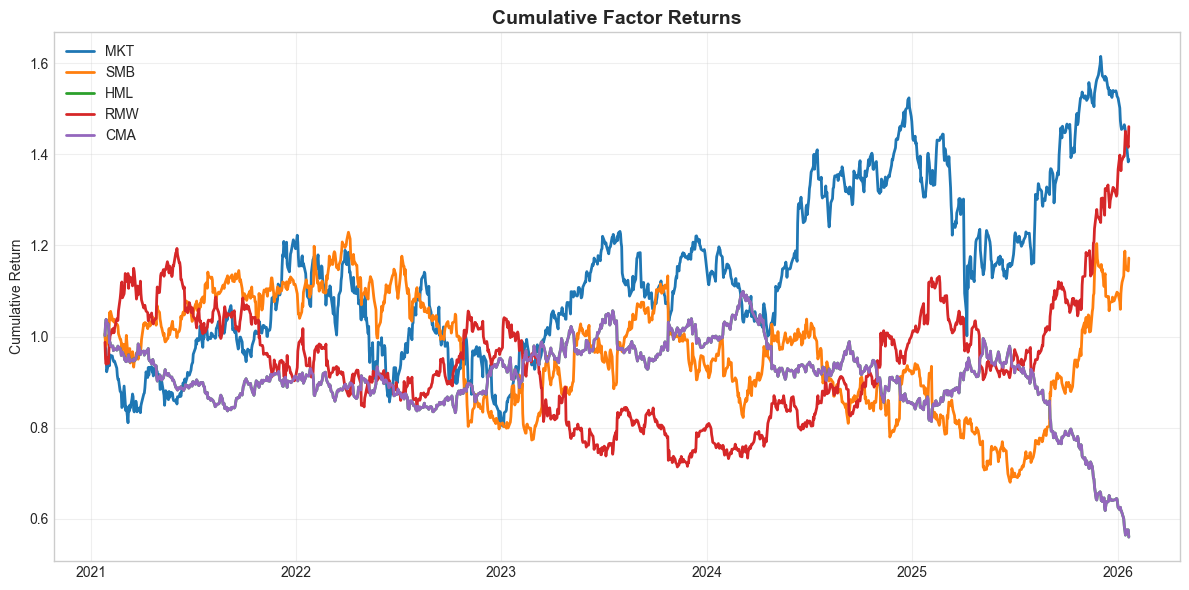

In [20]:
print("\n" + "="*70)
print("FACTOR STATISTICS")
print("="*70)

stats = pd.DataFrame({
    'Mean (Ann.)': factors5.mean() * TRADING_DAYS,
    'Vol (Ann.)': factors5.std() * np.sqrt(TRADING_DAYS),
    'Sharpe': (factors5.mean() / factors5.std()) * np.sqrt(TRADING_DAYS),
    'Skewness': factors5.skew(),
    'Kurtosis': factors5.kurtosis()
}).round(4)

print(stats)

# Cumulative factor performance
fig, ax = plt.subplots(figsize=(12, 6))

for col in factors5.columns:
    cum = (1 + factors5[col]).cumprod()
    ax.plot(cum, label=col, linewidth=2)

ax.set_title('Cumulative Factor Returns', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Diagnostics

In [21]:
# Detailed regression output for one stock
print("\n" + "="*60)
print("DETAILED FF5 REGRESSION: AAPL")
print("="*60)

if 'AAPL' in returns.columns:
    model = run_ff_regression(returns['AAPL'], factors5, daily_rf)
    print(model.summary())


DETAILED FF5 REGRESSION: AAPL
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.111e+33
Date:                Thu, 22 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:14:14   Log-Likelihood:                 47770.
No. Observations:                1253   AIC:                        -9.553e+04
Df Residuals:                    1248   BIC:                        -9.551e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.337e-18

## Key Takeaways

1. **FF5 adds Profitability (RMW) and Investment (CMA)** to the 3-factor model
2. **More factors = Higher R²** but beware of overfitting
3. **RMW captures** profitable vs weak firms
4. **CMA captures** conservative vs aggressive investment
5. **Alpha typically decreases** as more factors explain returns

### Factor Interpretation
| Factor | Positive Beta | Negative Beta |
|--------|--------------|---------------|
| SMB | Small-cap tilt | Large-cap tilt |
| HML | Value tilt | Growth tilt |
| RMW | Quality tilt | Low-quality tilt |
| CMA | Conservative | Aggressive |

---
*Next: Day 4 - Arbitrage Pricing Theory (APT)*

## 🔴 PROS & CONS: FF5 Factor

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [22]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - FF5 Factor Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:14

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
